# Chapter 3 : 분류(Classification)

In [1]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴드
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## 1. MNIST data
### 손으로 쓴 70000개의 작은 숫자 이미지를 모은 데이터셋

In [2]:
# 데이터 불러들이기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.int)

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

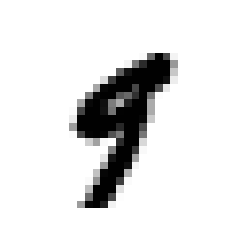

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

plt.show()

### MNIST 데이터셋에서 추출한 숫자 이미지

In [6]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [7]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

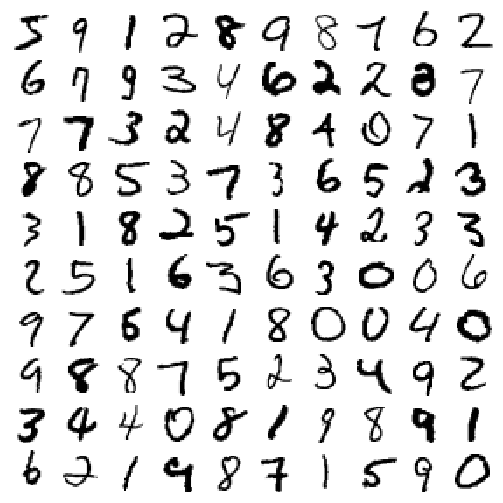

In [8]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

In [9]:
y[36000]

9

In [10]:
# training set, test set 
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
import numpy as np
# 훈련세트를 섞어서 모든 교차 검증 폴드가 비슷해지도록 만들기
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 2. 이진 분류기 훈련(binary classifier training)

In [12]:
y_train_5 = (y_train == 5) # 5는 True, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

In [13]:
from sklearn.linear_model import SGDClassifier
# 확률적 경사 하강법 (Stochastic Gradient Descent)
sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [14]:
sgd_clf.predict([some_digit]) # 실제값이 9이므로 False 출력

array([False])

## 3. 성능 측정
### 교차 검증(K-fold crossvalidation)

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") # 3-fold crossvalidation

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.964 , 0.9579, 0.9571])

In [16]:
# 위의 cross_val_score() 와 비슷한 결과 제공

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.964


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.9579
0.9571


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [17]:
from sklearn.base import BaseEstimator
# 모든 이미지를 '5아님' 클래스로 분류하는 더미 분류기 만들기
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90745, 0.9125 ])

### 오차행렬(confusion matrix)

In [19]:
from sklearn.model_selection import cross_val_predict
# 각 테스트 폴드에서 얻은 예측 반환
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [20]:
from sklearn.metrics import confusion_matrix
# 오차행렬 계산
confusion_matrix(y_train_5, y_train_pred)

array([[54058,   521],
       [ 1899,  3522]], dtype=int64)

In [21]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### 정밀도(precision), 재현율(recall)

In [22]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) # 정확도

0.8711352955725946

In [23]:
3522 / (3522 + 521)

0.8711352955725946

In [24]:
recall_score(y_train_5, y_train_pred) # 재현율

0.6496956281128943

In [25]:
3522 / (3522 + 1899)

0.6496956281128943

In [26]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred) # F1 점수

0.7442941673710904

In [27]:
3522 / (3522 + (1899 + 521) / 2)

0.7442941673710904

#### precision / recall -> trade off
- 정밀도 증가 -> 재현율 감소
- 재현율 감소 -> 정밀도 증가

In [28]:
y_scores = sgd_clf.decision_function([some_digit]) # 실제 임곗값에 사용된 점수 (결정점수)
y_scores

array([-400042.39513131])

In [29]:
# 임곗값을 높이면 재현율이 줄어듬
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [30]:
# 임곗값을 낮추면 재현율이 늘어남
threshold = -500000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function") # 결정 점수 반환

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


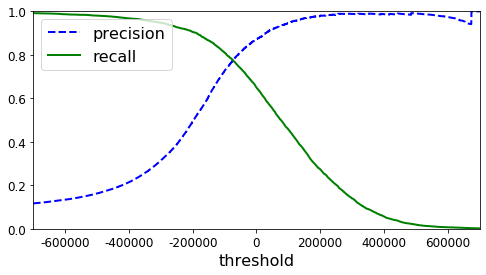

In [32]:
# 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산 후 그래프 그리기

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="recall", linewidth=2)
    plt.xlabel("threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])

plt.show()

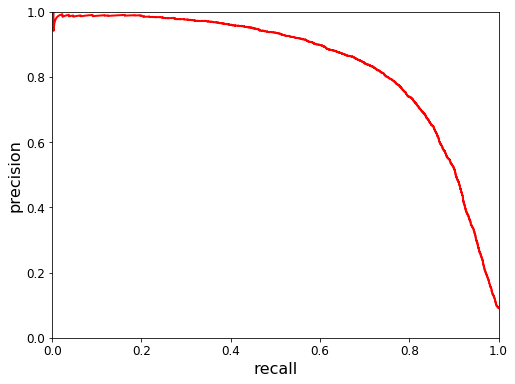

In [33]:
# 정밀도 vs 재현율
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "r-", linewidth=2)
    plt.xlabel("recall", fontsize=16)
    plt.ylabel("precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

plt.show()

In [34]:
# 정밀도 90%를 달성하는 분류기 만들기
y_train_pred_90 = (y_scores > 70000)

In [35]:
precision_score(y_train_5, y_train_pred_90)

0.9309882747068676

In [36]:
recall_score(y_train_5, y_train_pred_90)

0.5126360450101457

### ROC(receiver operating characteristic) curve
- 민감도(재현율)에 대한 1-특이도 그래프

In [37]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores) # 민감도, 1-특이도, 임곗값

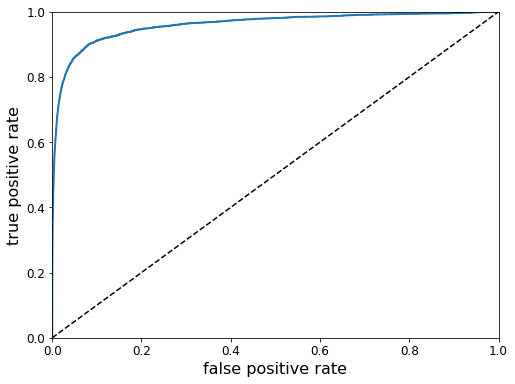

In [38]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('false positive rate', fontsize=16)
    plt.ylabel('true positive rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)

plt.show()

In [39]:
from sklearn.metrics import roc_auc_score
# ROC 곡선 아래의 면적 : 1에 가까울수록 좋은 분류기임
roc_auc_score(y_train_5, y_scores)

0.9598058535696421

#### 랜덤포레스트와 확률적 경사 하강법의 ROC 곡선 비교

In [40]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [41]:
y_scores_forest = y_probas_forest[:, 1] # 양상 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

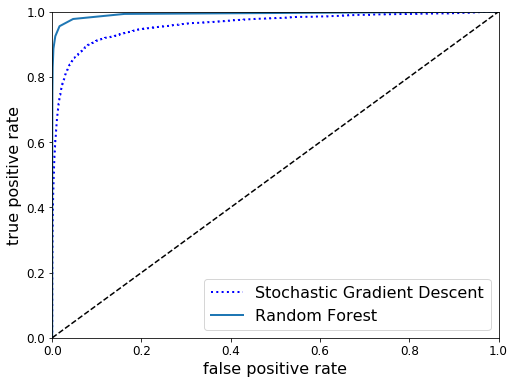

In [42]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="Stochastic Gradient Descent")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [43]:
roc_auc_score(y_train_5, y_scores_forest)

0.9928250745111685

In [44]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest) # 정밀도

0.9870386643233744

In [45]:
recall_score(y_train_5, y_train_pred_forest) # 재현율

0.8288138719793396

## 4. 다중분류(multinomial classifier)

In [46]:
sgd_clf.fit(X_train, y_train) # 다중분류 SGD
sgd_clf.predict([some_digit]) # y[36000]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([9])

In [47]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores # 9에 해당하는 결정점수가 가장 높음

array([[-780634.17445014, -367988.10902669, -857510.2219226 ,
        -109587.17435534,   -6978.239532  , -120352.38122307,
        -785831.32198027, -377771.38059503, -198143.6559996 ,
         107815.22648992]])

In [48]:
from sklearn.multiclass import OneVsOneClassifier # 일대일 전략을 사용하도록 강제
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit]) # 4라고 잘못 분류

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\s

array([4])

In [49]:
len(ovo_clf.estimators_)

45

In [50]:
forest_clf.fit(X_train, y_train) # 랜덤포레스트 분류기 적용
forest_clf.predict([some_digit])

array([9])

In [51]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0.9]])

In [52]:
# 3-fold crossvalidation with SGD
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.87217556, 0.87109355, 0.83892584])

In [53]:
# 입력 스케일 조정을 통한 분류기 성능 향상
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.91106779, 0.9080454 , 0.90888633])

## 5. 에러 분석

In [54]:
# 오차행렬
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5741,    2,   22,   11,   11,   40,   48,    7,   39,    2],
       [   2, 6457,   49,   28,    6,   45,    9,   11,  125,   10],
       [  55,   35, 5323,   98,   79,   24,  104,   62,  162,   16],
       [  47,   40,  140, 5314,    3,  254,   34,   57,  141,  101],
       [  19,   25,   41,    9, 5360,   10,   56,   36,   77,  209],
       [  76,   39,   30,  174,   76, 4610,  110,   29,  168,  109],
       [  36,   20,   42,    2,   39,   89, 5632,    7,   50,    1],
       [  23,   19,   61,   26,   54,   11,    7, 5826,   14,  224],
       [  56,  149,   78,  143,   12,  163,   56,   27, 5012,  155],
       [  46,   30,   26,   83,  160,   35,    3,  207,   74, 5285]],
      dtype=int64)

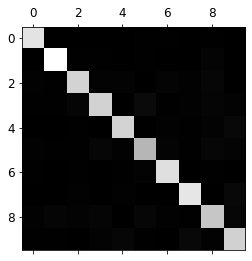

In [55]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

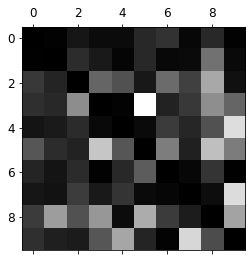

In [56]:
# 오차행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0) # 주대각선만 0으로 채움 (제대로 분류된 경우에 한함)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray) # 행 : 실제, 열 : 예측
plt.show()

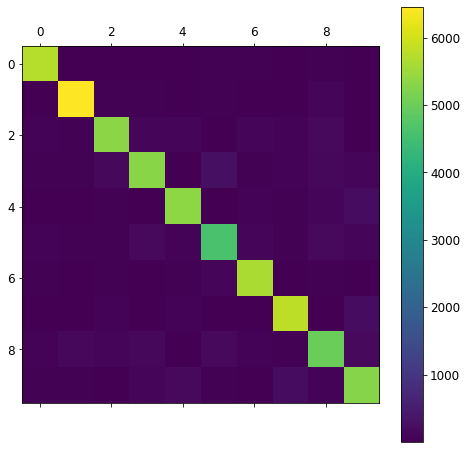

In [57]:
def plot_confusion_matrix(matrix):
    """컬러 오차 행렬을 원할 경우"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
plot_confusion_matrix(conf_mx)
plt.show()

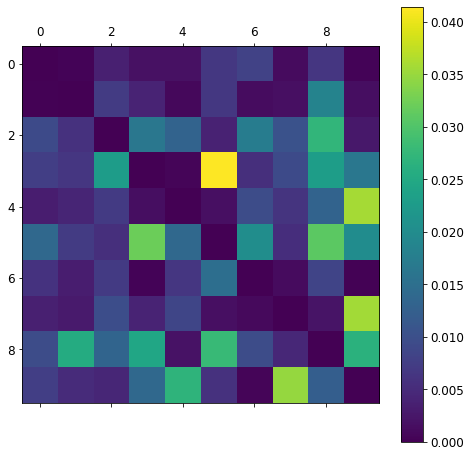

In [58]:
plot_confusion_matrix(norm_conf_mx) # 밝은 색상일수록 잘못 분류된 경우가 많음을 뜻함
plt.show()

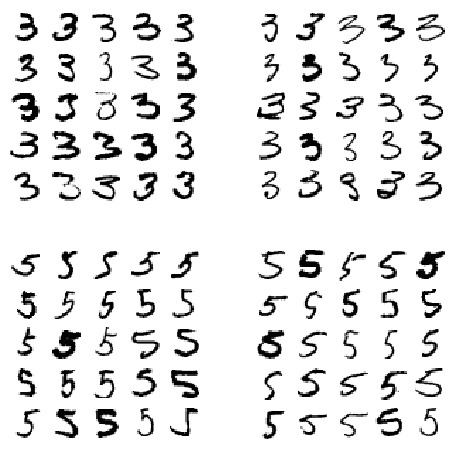

In [59]:
# 3과 5의 sample
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

plt.show()

## 6. 다중 레이블 분류(multilabel classification)

In [60]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) # 숫자가 7,8,9 중 하나인지
y_train_odd = (y_train % 2 == 1) # 숫자가 홀수인지
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [61]:
knn_clf.predict([some_digit]) # 숫자 9는 7 이상이면서 홀수 -> 모두 True로 올바르게 분류됨

array([[ True,  True]])

In [62]:
# 모든 레이블에 대한 F1점수의 평균 계산 (시간이 굉장히 오래 걸림)
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9768224011622285

## 7. 다중 출력 분류(multioutput classification)

In [63]:
# 타깃 이미지(원본 MNIST 이미지)의 픽셀 강도에 노이즈 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

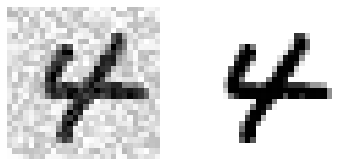

In [64]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

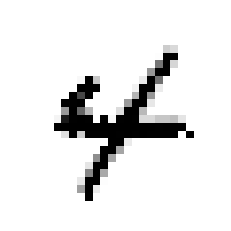

In [65]:
# 분류기 훈련 후 노이즈가 제거된 결과물 확인
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)